In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import torchvision.transforms as tfrm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset

import os
import PIL
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Definitions

In [4]:
def drive_path(path):
  folder_path = str(Path(path).parent)

  if folder_path.endswith('Whatzit'):
    return os.path.join('/content/drive/MyDrive/Additional Datasets/Whatzit', os.path.basename(path))

  if folder_path.endswith('dataset'):
    return os.path.join('/content/drive/MyDrive/Domain Expert-Datasets/email dataset', os.path.basename(path))
  
  if folder_path.endswith('labeled'):
    return os.path.join('/content/drive/MyDrive/Fellows Resources/labeled', os.path.basename(path))



def change_path(row):
  img_path_AP = row['image_path_AP']
  img_path_ML = row['image_path_ML']

  row['image_path_AP'] = drive_path(img_path_AP)
  row['image_path_ML'] = drive_path(img_path_ML)

  return row


In [5]:
class ImageDatasetFromDF(Dataset):
  def __init__(self, root_directory, dataframe, image_label_AP, image_label_ML, labels, mapping, transforms=None):

    self.df = dataframe.reset_index(drop=True)
    self.dir = root_directory
    self.tfrm = transforms

    self.labels = labels
    self.image_label_AP = image_label_AP
    self.image_label_ML = image_label_ML

    self.class_to_label = mapping

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    filename_AP = os.path.join(str(self.dir), str(self.df.loc[index, self.image_label_AP]))
    filename_ML = os.path.join(str(self.dir), str(self.df.loc[index, self.image_label_ML]))

    labels = torch.tensor(self.class_to_label[self.df.loc[index, self.labels]], dtype=torch.long)

    image_AP = PIL.Image.open(filename_AP).convert('RGB')
    image_ML = PIL.Image.open(filename_ML).convert('RGB')

    if self.tfrm:
      image_AP = self.tfrm(image_AP)
      image_ML = self.tfrm(image_ML)
    
    return image_AP, image_ML, labels

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        else:
            return dataset.df["Product"][idx]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


In [6]:
class SiameseMultiClass(nn.Module):

  results = {
      'train': {
          'loss': []
      },
      'val': {
          'loss': [],
          'acc': []
      },
  }

  epoch = 0
  history = []

  def __init__(self, num_classes, record=True, verbose=True):
    super(SiameseMultiClass, self).__init__()

    self.res1 = nn.Sequential(*(list(torchvision.models.resnet101(pretrained=True, progress=False).children())[:-1]))
    self.res2 = nn.Sequential(*(list(torchvision.models.resnet101(pretrained=True, progress=False).children())[:-1]))

    self.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, num_classes)
    )

    self.record = record
    self.verbose = verbose
  
  def forward(self, inp1, inp2):
    out1 = self.res1(inp1)
    out2 = self.res2(inp2)

    out1 = out1.reshape(-1, out1.shape[1])
    out2 = out2.reshape(-1, out2.shape[1])

    return self.fc(torch.cat([out1, out2], dim=1))

  def train_step(self, xb):
    inp1, inp2, labels = xb 
    out = self(inp1, inp2)
    loss = F.cross_entropy(out, labels)

    self.results['train']['loss'].append(loss.cpu().item())
    return loss

  def val_step(self, xb):
    inp1, inp2, labels = xb
    out = self(inp1, inp2)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    
    self.results['val']['loss'].append(loss.cpu().item())
    self.results['val']['acc'].append(acc.cpu().item())

  def epoch_end(self):
    train_loss = torch.tensor(self.results['train']['loss']).mean().item()
    val_loss = torch.tensor(self.results['val']['loss']).mean().item()
    val_acc = torch.tensor(self.results['val']['acc']).mean().item()

    if self.record:
      self.history.append({
          'epoch': self.epoch,
          'train_loss': train_loss,
          'val_loss': val_loss,
          'val_acc': val_acc
      })
    if self.verbose:
      print(f'Epoch [{self.epoch}]: train_loss: {train_loss}, val_loss: {val_loss}, val_acc: {val_acc}')
    
    self.reset_results()
    self.epoch += 1

  def reset_results(self):
    self.results = {
        'train': {
            'loss': []
        },
        'val': {
            'loss': [],
            'acc': []
        },
    }

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [7]:
def show_batch(dl):
  for image_AP, image_ML, labels in dl:
    image_AP = image_AP.cpu()
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([]);
    ax.imshow(make_grid(image_AP[:64], nrow=8).permute(1,2, 0).clamp(0,1))
    break


# Run

In [8]:
train_df = pd.read_csv("/content/drive/MyDrive/Concatenate/Merged Datasets/train.csv").apply(change_path, axis=1)
val_df = pd.read_csv("/content/drive/MyDrive/Concatenate/Merged Datasets/val.csv").apply(change_path, axis=1)

label_to_idx = {label:idx for idx, label in enumerate(list(train_df["Product"].value_counts().index))}

len(train_df), len(val_df)

(1796, 344)

In [9]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
img_size = (240, 240)

transform_train = tfrm.Compose([
    tfrm.RandomHorizontalFlip(),
    tfrm.Resize(img_size),
    tfrm.ToTensor(),
    tfrm.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0] == 1 else x),
    tfrm.Normalize(mean=mean, std=std)
  ])

transform_val = tfrm.Compose([
    tfrm.Resize(img_size),
    tfrm.ToTensor(),
    tfrm.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0] == 1 else x),
    tfrm.Normalize(mean=mean, std=std)
    ])


train_ds = ImageDatasetFromDF('', train_df, 'image_path_AP', 'image_path_ML', 'Product', label_to_idx, transform_train)
val_ds = ImageDatasetFromDF('', val_df, 'image_path_AP', 'image_path_ML', 'Product', label_to_idx, transform_val)



BATCH_SIZE = 32
train_dl = DataLoader(train_ds, BATCH_SIZE, sampler=ImbalancedDatasetSampler(train_ds), num_workers=4)
val_dl = DataLoader(val_ds, BATCH_SIZE, sampler=ImbalancedDatasetSampler(val_ds), num_workers=4)

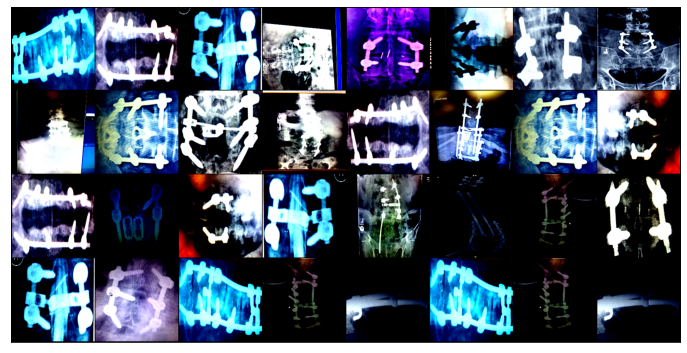

In [10]:
show_batch(train_dl)

In [11]:
def train(epochs, train_loader, val_loader, lr, tuning = False):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  model = SiameseMultiClass(len(label_to_idx))
  model.to(device)

  opt = torch.optim.Adam(model.parameters(), lr)
  
  for epoch in range(epochs):
    torch.cuda.empty_cache()
    model.train()

    for xb in tqdm(train_loader, total=len(train_loader)):
      xb = to_device(xb, device)
      loss = model.train_step(xb)

      loss.backward()

      opt.step()
      opt.zero_grad()


    model.eval()

    for xb in tqdm(val_loader, total=len(val_loader)):
      xb = to_device(xb, device)
      model.val_step(xb)

    model.epoch_end()

  if tuning:
    return model.history[-1]['val_loss']

  return model

In [43]:
lr = 2e-4
model = train(5, train_dl, val_dl, lr)


Epoch [0]: train_loss: 0.39085426926612854, val_loss: 4.143382549285889, val_acc: 0.2904829680919647



Epoch [1]: train_loss: 0.08021840453147888, val_loss: 3.7010445594787598, val_acc: 0.35132578015327454



Epoch [2]: train_loss: 0.06301364302635193, val_loss: 6.311807632446289, val_acc: 0.3125



Epoch [3]: train_loss: 0.19457833468914032, val_loss: 5.494204521179199, val_acc: 0.2708333134651184



Epoch [4]: train_loss: 0.1531725376844406, val_loss: 3.6271188259124756, val_acc: 0.47632578015327454


# Results

In [44]:
@torch.no_grad()
def predict(model, img1, img2):

  # hook
  activation = {}
  def get_activation(name):
    def hook(model, input, output):
      output = output.reshape(output.size(0), -1)
      activation[name] = output.cpu().detach()
    return hook

  model.fc[1].register_forward_hook(get_activation('linear'))

  model.eval()
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  img1, img2 = to_device([img1, img2], device)
  output = model(img1, img2)

  _, preds = torch.max(output, dim=1)
  return preds.cpu().detach(), activation['linear']


In [45]:
!pip install --quiet plotly-express

import numpy as np
import seaborn as sns
import plotly_express as px
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [46]:
labels = []
preds = []
manifolds = []

for xb in val_dl:
  img1, img2, label = xb
  pred, manifold = predict(model, img1, img2)
  preds.append(pred.reshape(-1, ))
  labels.append(label.reshape(-1, ))
  manifolds.append(manifold)

labels = torch.stack(labels[:-1]).reshape(-1,)
preds = torch.stack(preds[:-1]).reshape(-1,)
manifolds = torch.stack(manifolds[:-1]).reshape(-1, 2048)

acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))

print("Val accuracy: ", acc.detach().item())

Val accuracy:  0.44999998807907104


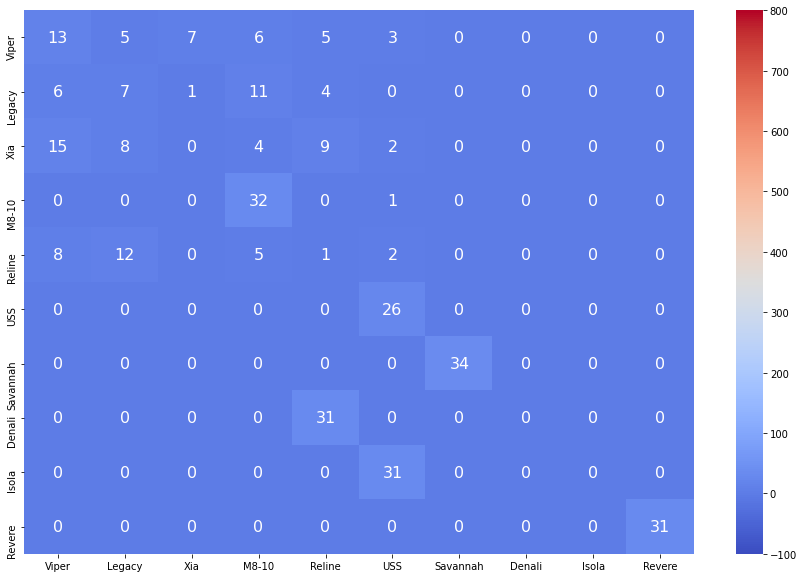

In [47]:
cm = confusion_matrix(labels.numpy(), preds.numpy())
products = list(label_to_idx.keys())
plt.figure(figsize=(15,10))
sns.heatmap(cm, cmap='coolwarm', vmin=-100, vmax=800, annot=True, annot_kws={'size':16}, xticklabels=products, yticklabels=products)

In [48]:
embeddings = TSNE(n_components=3).fit_transform(manifolds)
embeddings_label = np.concatenate([embeddings, labels.reshape(-1, 1).numpy()], axis=1)
embeddings_df = pd.DataFrame(embeddings_label, columns=["x", "y", "z", "label"])
embeddings_df['label'] = embeddings_df['label'].map({idx: label for label, idx in label_to_idx.items()})

In [49]:
px.scatter_3d(embeddings_df, x='x', y='y', z='z', 
                    color='label')